# Corelarea cu Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importul bibliotecilor.

In [ ]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Calea spre baza de date.

In [ ]:
# Calea de acces de bază pentru fisiere
data_dir = '/content/drive/MyDrive/Insect Village Synthetic Dataset/Insect Classes/Insect Classes'

# Incarcarea imaginilor pentru antrenare si testare.

In [ ]:
# Utilizarea ImageDataGenerator pentru a încărca imaginile pentru antrenarea și testarea modelului CNN
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 9000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


# Inițializarea modelului preantrenat InceptionV3

In [ ]:
# Inițializarea modelului InceptionV3 (preantrenat) cu imagini de intrare cu dimensiunile (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Încarcă parametrii pentru modelul InceptionV3.
base_model.load_weights('/content/drive/MyDrive/InceptionV3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setează antrenarea tuturor straturilor modelului InceptionV3 la valoarea 'False'.
base_model.trainable = False

# Adăugare strat personalizat.

In [ ]:
# Adăugarea unor straturi suplimentare la sfârșitul modelului, conform cerințelor noastre.
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax') # 10 neuroni de ieșire pentru 10 clase.
])

In [ ]:
# Se utilizeaza Optimizatorul Adam pentru a seta rata de învățare a modelului nostru final.
opt = optimizers.Adam(learning_rate=0.0001)

# Compilarea și setarea parametrilor pe care dorim să-i folosească modelul nostru.
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# Vizualizarea sintezei modelului și a graficului.

In [ ]:
# Vizualizarea sintezei modelului
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
____________________________________

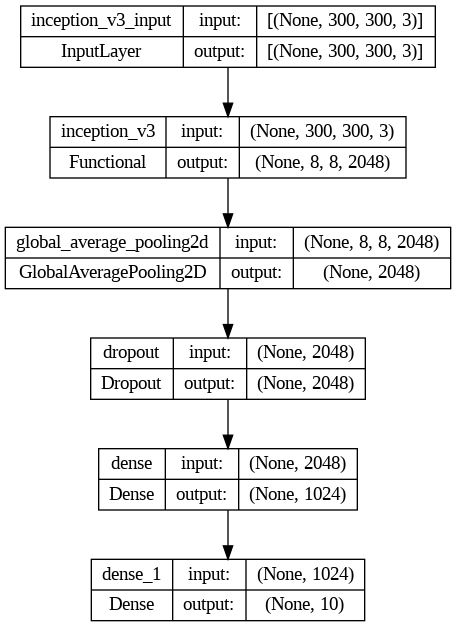

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# Construirea modelului.

In [ ]:
# Setarea parametrilor pentru model.
batch_size = 32
epochs = 10

# Separarea datelor de antrenare și de testare.
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [ ]:
# Calcularea parametrilor pentru model.
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 281
validation_steps : 31


# Antrenarea modelului.

In [ ]:
# Calea fișierului pentru stocarea modelelor antrenate.
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Utilizarea funcției ModelCheckpoint pentru a antrena și stoca cele mai bune modele.
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Antrenarea modelului.
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
281/281 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.6743
Epoch 1: val_accuracy improved from -inf to 0.80040, saving model to ./model_01-0.80.h5
281/281 [==============================] - 2988s 11s/step - loss: 1.0440 - accuracy: 0.6743 - val_loss: 0.6498 - val_accuracy: 0.8004
Epoch 2/10
281/281 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.7793
Epoch 2: val_accuracy improved from 0.80040 to 0.81855, saving model to ./model_02-0.82.h5
281/281 [==============================] - 2872s 10s/step - loss: 0.6846 - accuracy: 0.7793 - val_loss: 0.5710 - val_accuracy: 0.8185
Epoch 3/10
281/281 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.8001
Epoch 3: val_accuracy did not improve from 0.81855
281/281 [==============================] - 2778s 10s/step - loss: 0.6093 - accuracy: 0.8001 - val_loss: 0.5532 - val_accuracy: 0.8165
Epoch 4/10
281/281 [==============================] - ETA: 0s - loss: 0.5677 - a

# Evaluarea modelului.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Calcularea pierderilor și preciziei pe baza datelor de validare.
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

32/32 [==============================] - 177s 6s/step - loss: 0.4408 - accuracy: 0.8460
test accuracy :  0.8460000157356262


In [ ]:
# Verificăm folderul nostru și importăm modelul cu cea mai mare precizie de validare.
loaded_best_model = keras.models.load_model("./model_03-0.82.h5")

# Funcție personalizată pentru încărcarea și prezicerea etichetei pentru imagine.
def predict(img_rel_path):
    # Importă imaginea din calea specificată cu dimensiunea (300, 300).
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Conversia imaginii într-o matrice
    img = image.img_to_array(img, dtype=np.uint8)

    # Scalarea valorilor matricii de imagini între 0 și 1.
    img = np.array(img)/255.0

    # Reprezentarea grafică a imaginii încărcate.
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Prezicerea unei etichete pentru imaginea încărcată.
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Matricea de etichete.
    labels = {0: 'Bees', 1: 'Beetles', 2: 'Butterfly', 3: 'Cicada', 4: 'Dragonfly', 5: 'Grasshopper',
              6: 'Moth', 7: 'Scorpion', 8: 'Snail', 9: 'Spider'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

    def plot_bar_x():
        # Realizarea graficelor.
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

# Testarea modelelor si afisarea graficelor

Prima imagine de test.

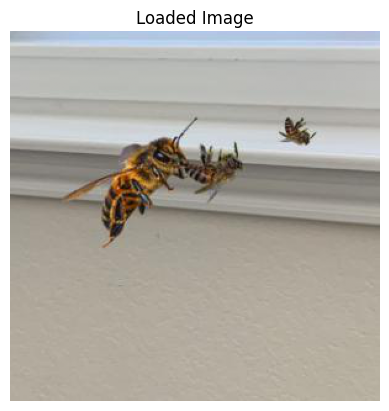

1/1 [==============================] - 1s 1s/step


Maximum Probability:  0.9962986
Classified: Bees 



-------------------Individual Probability--------------------------------

BEES : 99.63 %
BEETLES : 0.04 %
BUTTERFLY : 0.0 %
CICADA : 0.16 %
DRAGONFLY : 0.0 %
GRASSHOPPER : 0.02 %
MOTH : 0.0 %
SCORPION : 0.0 %
SNAIL : 0.0 %
SPIDER : 0.13 %


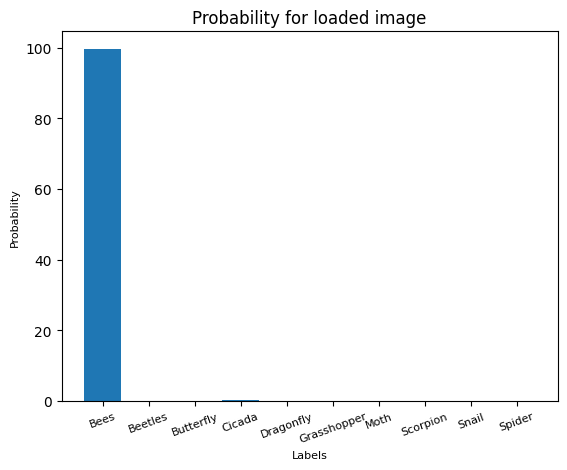

In [ ]:
predict("/content/drive/MyDrive/Insect Village Synthetic Dataset/Insect Classes/Insect Classes/Bees/00000025.jpg")

A doua imagine de test.

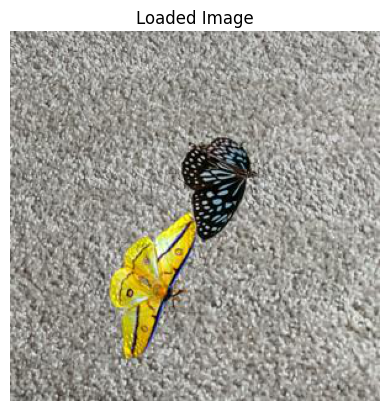

1/1 [==============================] - 0s 197ms/step


Maximum Probability:  0.9877109
Classified: Butterfly 



-------------------Individual Probability--------------------------------

BEES : 0.01 %
BEETLES : 0.0 %
BUTTERFLY : 98.77 %
CICADA : 0.03 %
DRAGONFLY : 0.0 %
GRASSHOPPER : 0.01 %
MOTH : 1.16 %
SCORPION : 0.0 %
SNAIL : 0.01 %
SPIDER : 0.0 %


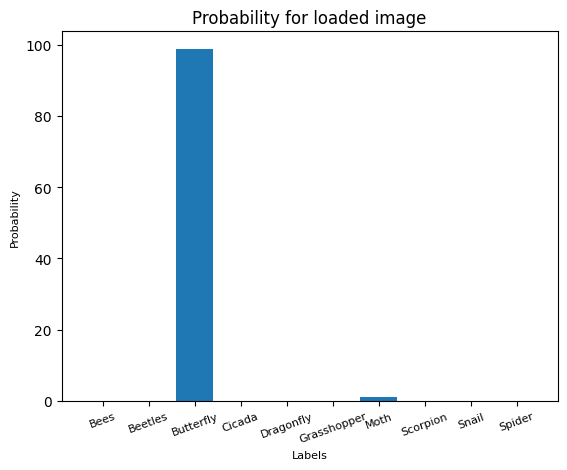

In [ ]:
predict("/content/drive/MyDrive/Insect Village Synthetic Dataset/Insect Classes/Insect Classes/Butterfly/00000006.jpg")

A patra imagine de test.

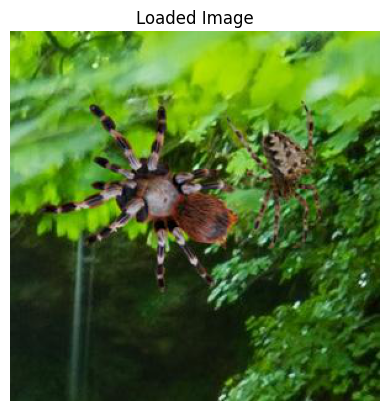

1/1 [==============================] - 0s 197ms/step


Maximum Probability:  0.98462033
Classified: Spider 



-------------------Individual Probability--------------------------------

BEES : 0.14 %
BEETLES : 0.03 %
BUTTERFLY : 0.02 %
CICADA : 0.56 %
DRAGONFLY : 0.17 %
GRASSHOPPER : 0.23 %
MOTH : 0.02 %
SCORPION : 0.34 %
SNAIL : 0.01 %
SPIDER : 98.46 %


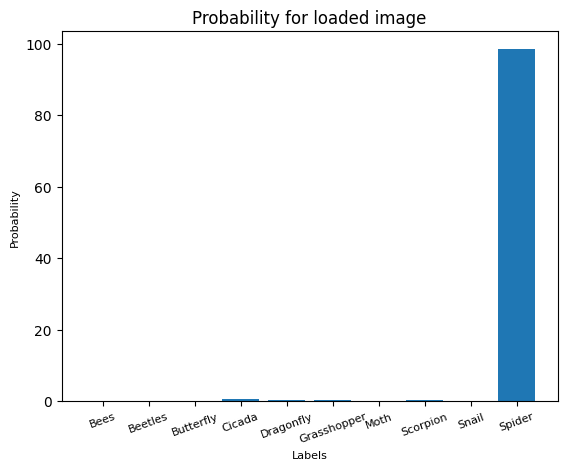

In [ ]:
predict("/content/drive/MyDrive/Insect Village Synthetic Dataset/Insect Classes/Insect Classes/Spider/00000002.jpg")

A cincea imagine de test.

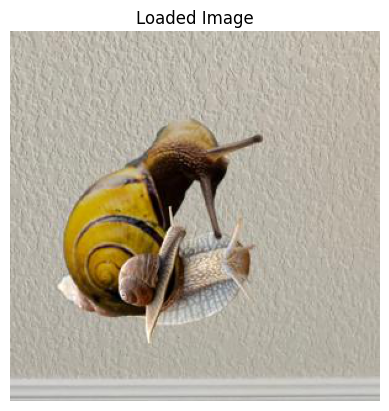

1/1 [==============================] - 0s 190ms/step


Maximum Probability:  0.9999763
Classified: Snail 



-------------------Individual Probability--------------------------------

BEES : 0.0 %
BEETLES : 0.0 %
BUTTERFLY : 0.0 %
CICADA : 0.0 %
DRAGONFLY : 0.0 %
GRASSHOPPER : 0.0 %
MOTH : 0.0 %
SCORPION : 0.0 %
SNAIL : 100.0 %
SPIDER : 0.0 %


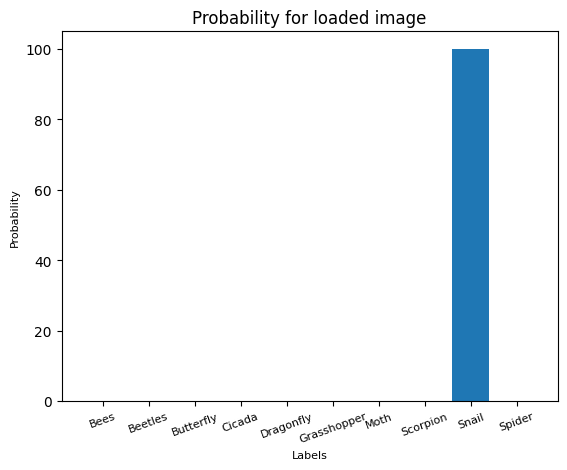

In [ ]:
predict("/content/drive/MyDrive/Insect Village Synthetic Dataset/Insect Classes/Insect Classes/Snail/00000009.jpg")

A sasea imagine de test.

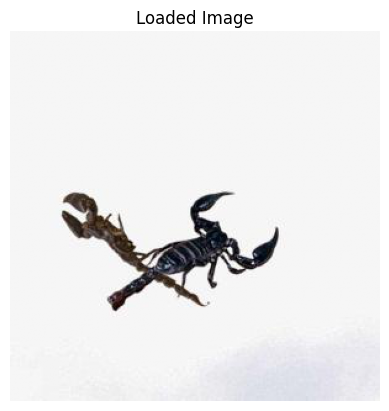

1/1 [==============================] - 0s 186ms/step


Maximum Probability:  0.9963201
Classified: Scorpion 



-------------------Individual Probability--------------------------------

BEES : 0.02 %
BEETLES : 0.04 %
BUTTERFLY : 0.0 %
CICADA : 0.09 %
DRAGONFLY : 0.02 %
GRASSHOPPER : 0.01 %
MOTH : 0.0 %
SCORPION : 99.63 %
SNAIL : 0.0 %
SPIDER : 0.18 %


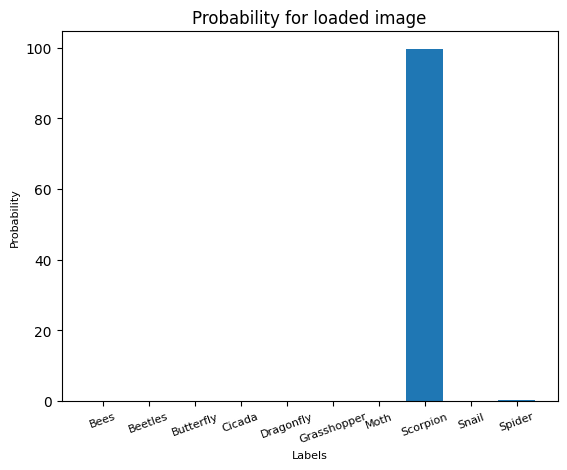

In [ ]:
predict("/content/drive/MyDrive/Insect Village Synthetic Dataset/Insect Classes/Insect Classes/Scorpion/00000005.jpg")

A saptea imagine de test.

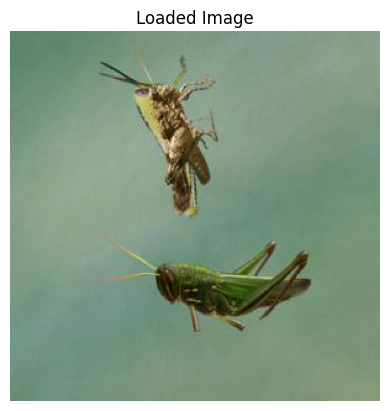

1/1 [==============================] - 0s 188ms/step


Maximum Probability:  0.9945851
Classified: Grasshopper 



-------------------Individual Probability--------------------------------

BEES : 0.0 %
BEETLES : 0.01 %
BUTTERFLY : 0.0 %
CICADA : 0.01 %
DRAGONFLY : 0.49 %
GRASSHOPPER : 99.46 %
MOTH : 0.02 %
SCORPION : 0.01 %
SNAIL : 0.0 %
SPIDER : 0.0 %


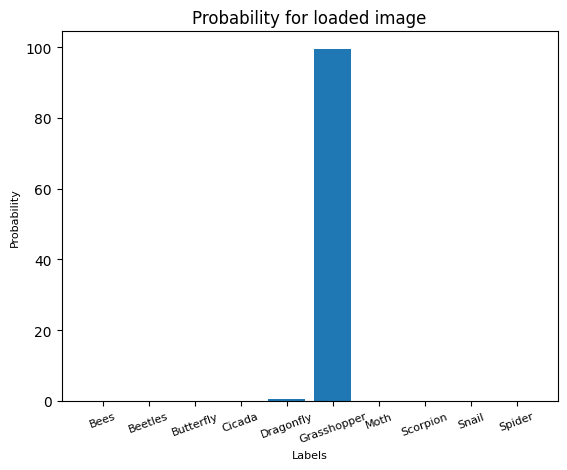

In [ ]:
predict("/content/drive/MyDrive/Insect Village Synthetic Dataset/Insect Classes/Insect Classes/Grasshopper/00000034.jpg")

A opta imagine de test.

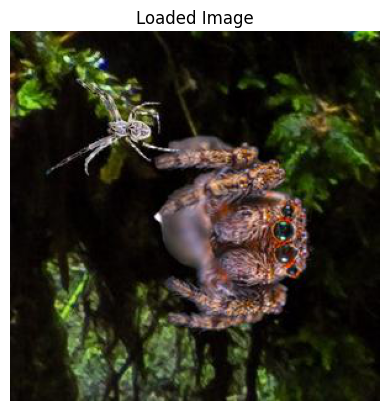

1/1 [==============================] - 0s 193ms/step


Maximum Probability:  0.96467817
Classified: Spider 



-------------------Individual Probability--------------------------------

BEES : 0.12 %
BEETLES : 0.1 %
BUTTERFLY : 0.03 %
CICADA : 1.48 %
DRAGONFLY : 0.01 %
GRASSHOPPER : 0.33 %
MOTH : 1.04 %
SCORPION : 0.18 %
SNAIL : 0.23 %
SPIDER : 96.47 %


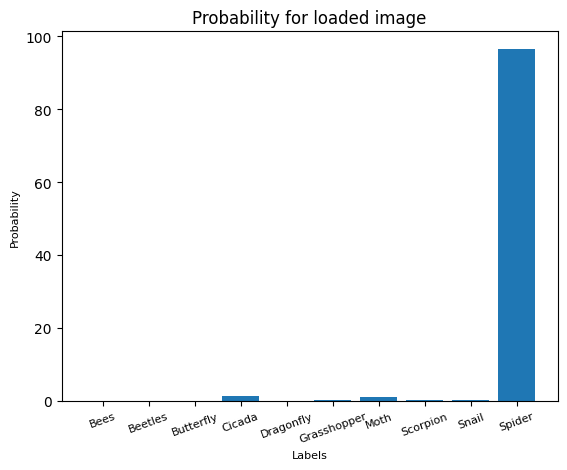

In [ ]:
predict("/content/drive/MyDrive/Insect Village Synthetic Dataset/Insect Classes/Insect Classes/Spider/00000067.jpg")